Want code to be able to:

1)  Use different algorithms
+ PCA
+ UMAP
+ t-SNE

2) Display different representations:
+ 2D embedding with color for labels
+ 2D embedding mapped to grid
+ 2D embedding with some examples for each cluster (cluster first then examples?)
+ 2D embedding with tool tip mouseover

In [1]:
%qtconsole

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

In [9]:
file_path = '../DATA/JZ1_01_04.nc'

posterior_density_ca1 = (xr.open_mfdataset(file_path,
                                           group='/posterior_density_ca1')
                         .sum(dim='state')
                         .sel(time=slice(0, 0.100))
                         .posterior_density)
replay_info = xr.open_mfdataset(file_path, group='/replay_info_ca1').to_dataframe()

In [3]:
posterior_density_ca1

<xarray.DataArray 'posterior_density' (concat_dim: 279, time: 151, position: 61)>
dask.array<shape=(279, 151, 61), dtype=float64, chunksize=(279, 151, 61)>
Coordinates:
  * time        (time) float64 0.0 0.0006667 0.001333 0.002 0.002667 ...
  * position    (position) float64 0.5821 1.746 2.911 4.075 5.239 6.404 ...
  * concat_dim  (concat_dim) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 ...

In [4]:
replay_info.head()

ripple_number      start_time        end_time animal  day  epoch  \
index                                                                     
0                  1 00:28:03.733866 00:28:03.821866    JZ1    1      2   
1                  2 00:28:04.379200 00:28:04.437866    JZ1    1      2   
2                  3 00:28:07.081866 00:28:07.135200    JZ1    1      2   
3                  4 00:28:08.576533 00:28:08.680533    JZ1    1      2   
4                  5 00:28:09.424533 00:28:09.501200    JZ1    1      2   

      ripple_duration   predicted_state  predicted_state_probability  \
index                                                                  
0     00:00:00.088000   Inbound-Reverse                     0.804074   
1     00:00:00.058666  Outbound-Reverse                     0.941178   
2     00:00:00.053333  Outbound-Reverse                     0.976718   
3     00:00:00.104000   Inbound-Forward                     0.899479   
4     00:00:00.076666   Inbound-Reverse                     0.905190   

      replay_task      ...      is_correct turn  x_position  y_position  \
index                  ...                                                
0         Inbound      ...           False        48.160357   47.060758   
1        Outbound      ...           False        47.188963   50.538471   
2        Outbound      ...           False        47.194515   53.834313   
3         Inbound      ...           False        49.202378   53.290960   
4         Inbound      ...           False        50.123770   51.770950   

       head_direction     speed linear_distance linear_position  \
index                                                             
0           -2.508798  2.569127       44.778097             NaN   
1           -3.096465  3.552531       42.241868             NaN   
2           -2.439185  1.063963       42.241868             NaN   
3           -2.663113  1.515308       42.241868             NaN   
4           -3.069813  2.132825       42.241868             NaN   

       lagged_linear_distance replay_motion  
index                                        
0                   44.776753          Away  
1                   42.241868          Away  
2                   42.241868          Away  
3                   42.241868          Away  
4                   42.241868          Away  

[5 rows x 28 columns]

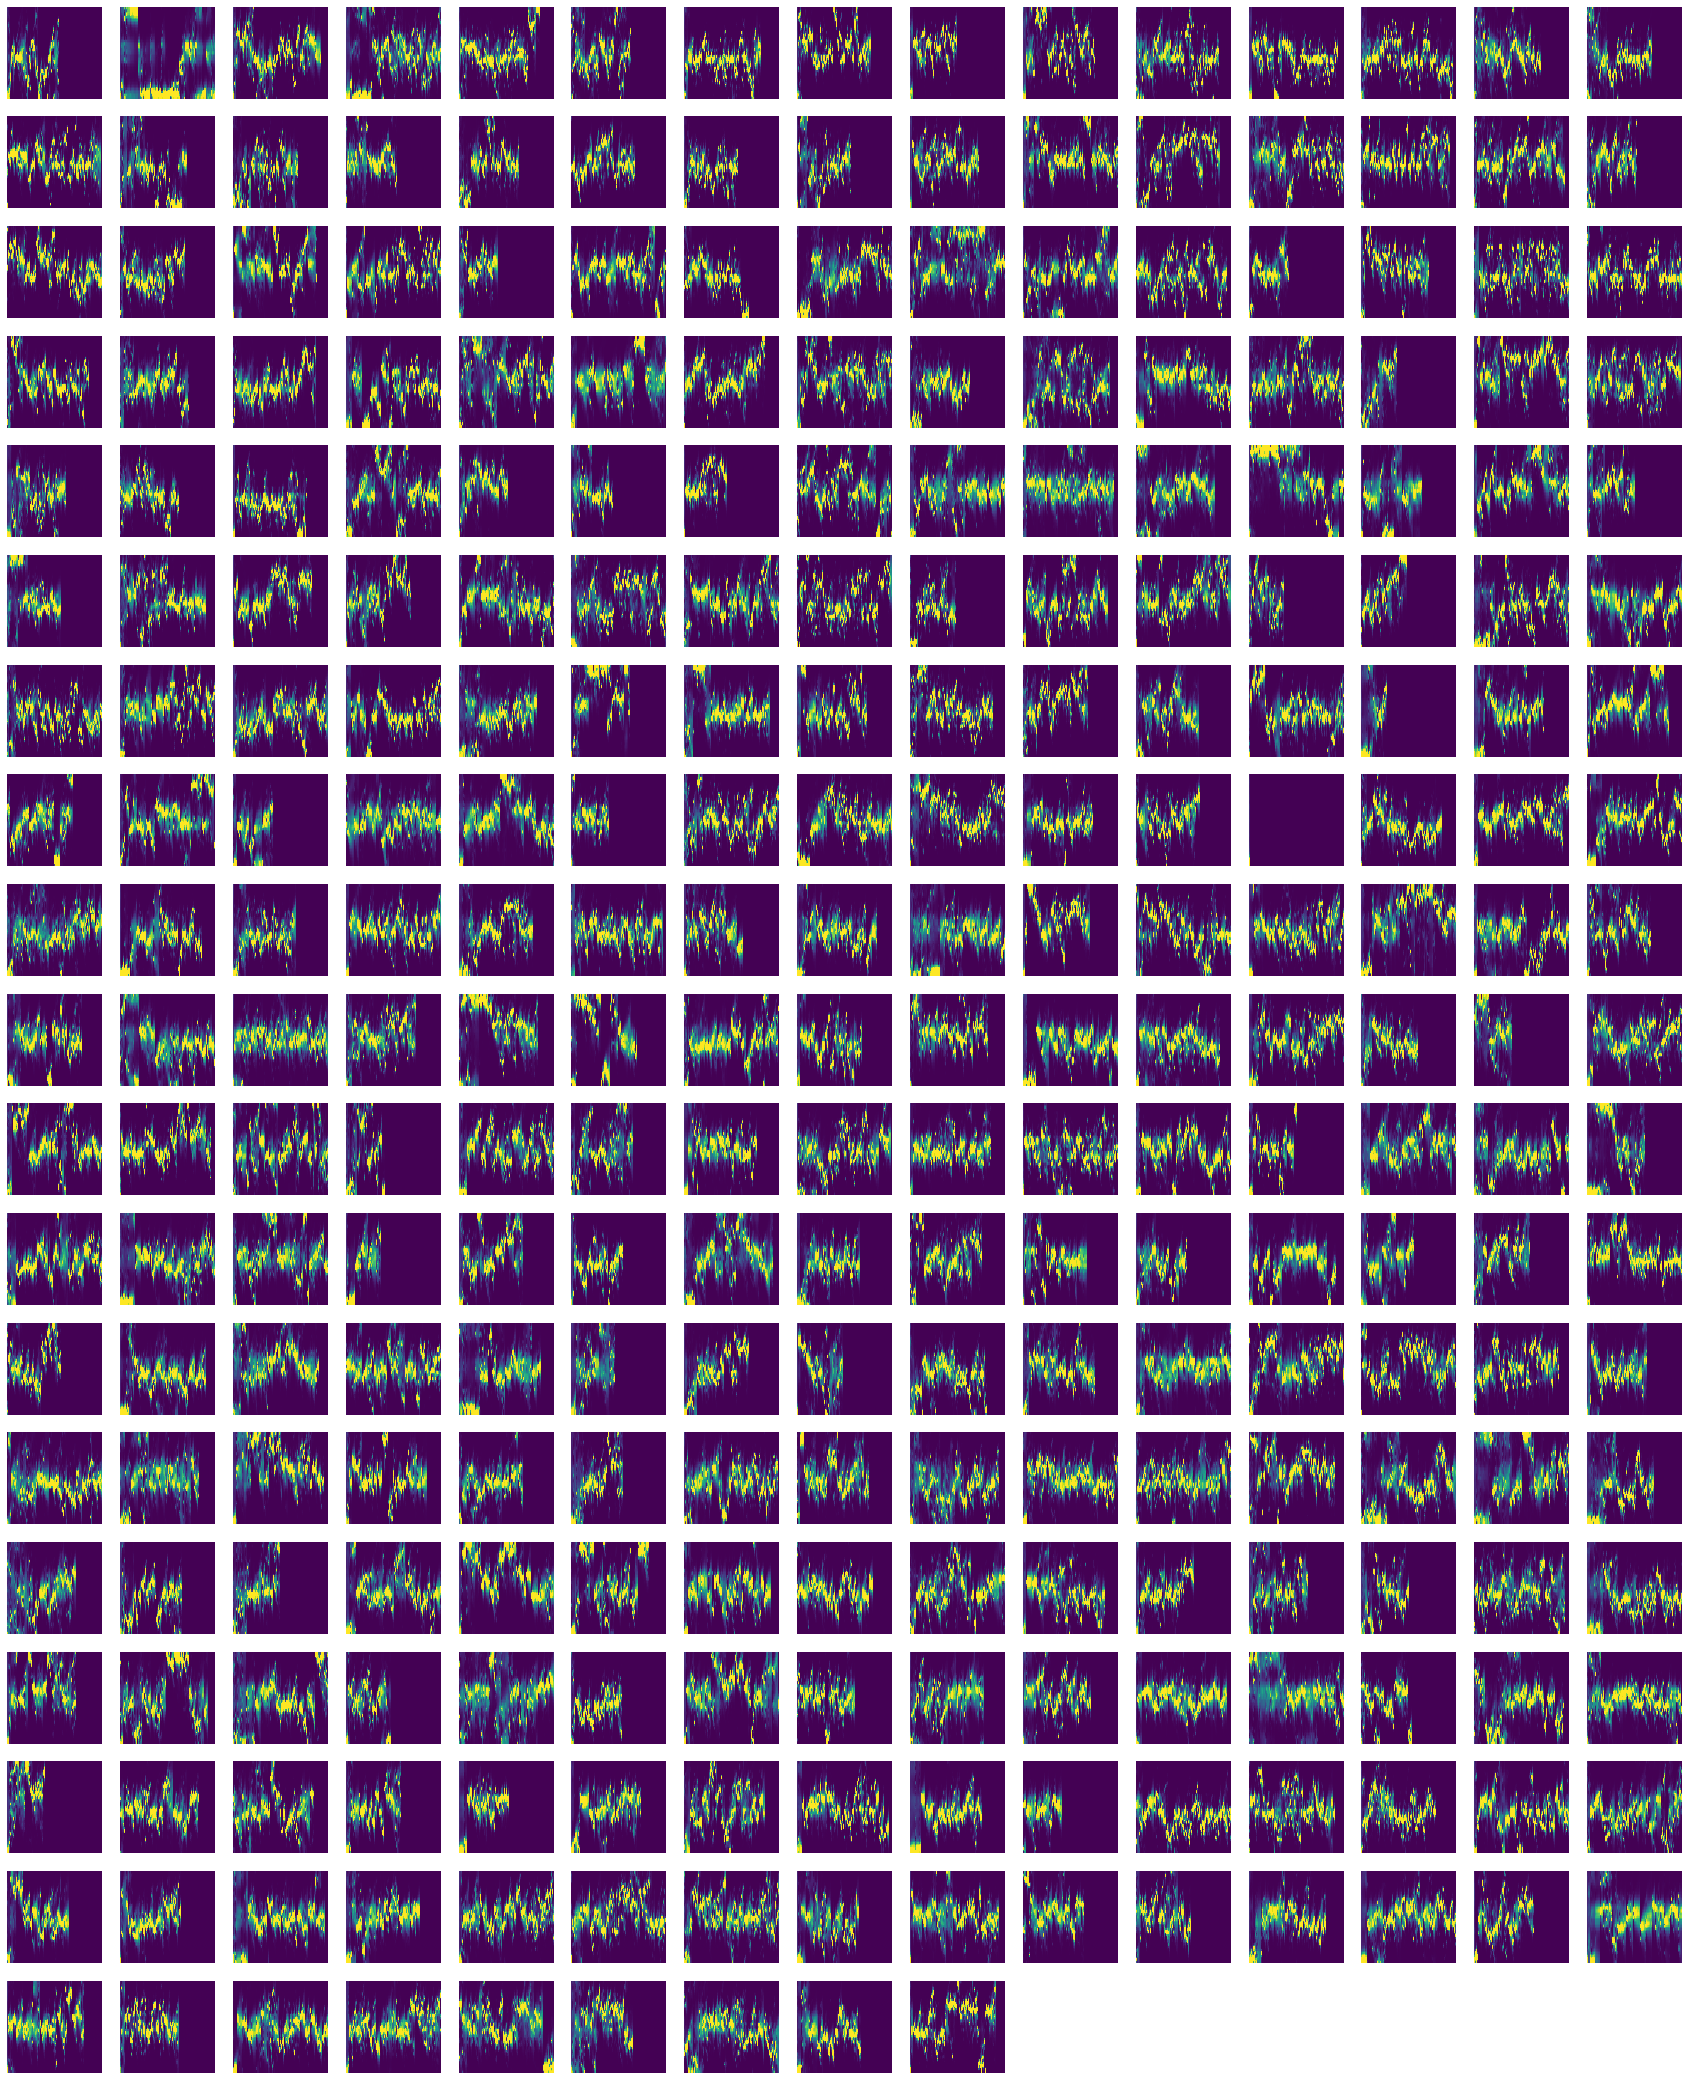

In [5]:
n_replay = posterior_density_ca1.concat_dim.size

vmax = float(posterior_density_ca1.compute().quantile(0.95).values)

col_wrap = 15
n_row = np.ceil(n_replay / col_wrap).astype(int)

fig, axes = plt.subplots(n_row, col_wrap,
                         figsize=(col_wrap * 2, n_row * 2),
                         sharex=True, sharey=True,
                         subplot_kw=dict(xticks=[], yticks=[]))

for replay_ind, ax in enumerate(axes.flat):
    try:
        ax.pcolorfast(posterior_density_ca1.isel(concat_dim=replay_ind).values.T,
                      cmap='viridis', vmin=0.0, vmax=vmax)
    except IndexError:
        pass

    ax.axis('off')


In [6]:
from matplotlib import offsetbox
import matplotlib.colors as colors

def plot_components(data, model, images=None, ax=None,
                    targets=None,
                    thumb_frac=0.05, cmap='gray'):
    ax = ax or plt.gca()
    
    proj = model.fit_transform(data)
    proj -= proj.min(axis=0)
    proj /= proj.max(axis=0)

    if (targets is not None) and np.issubdtype(targets.dtype, np.object_):
        labels = np.unique(targets)
        
        for label_ind, label in enumerate(labels):
            is_label = np.isin(targets, label)
            ax.plot(proj[is_label, 0], proj[is_label, 1], '.', label=label)
    else:
        ax.scatter(proj[:, 0], proj[:, 1], c=targets)
    
    if images is not None:
        vmax = np.quantile(images, 0.95)
        norm = colors.Normalize(vmin=0.0, vmax=vmax)
        min_dist_2 = (thumb_frac * max(proj.max(0) - proj.min(0))) ** 2
        shown_images = np.array([2 * proj.max(0)])

        for img_position, img in zip(proj, images):
            dist = np.sum((img_position - shown_images) ** 2, 1)
            if np.min(dist) < min_dist_2:
                # don't show points that are too close
                continue
            shown_images = np.vstack([shown_images, img_position])
            is_nonzero = np.sum(img, axis=0) > 0
            offset_img = offsetbox.OffsetImage(
                img[:, is_nonzero], cmap=cmap, norm=norm)
            imagebox = offsetbox.AnnotationBbox(offset_img, img_position)
            ax.add_artist(imagebox)

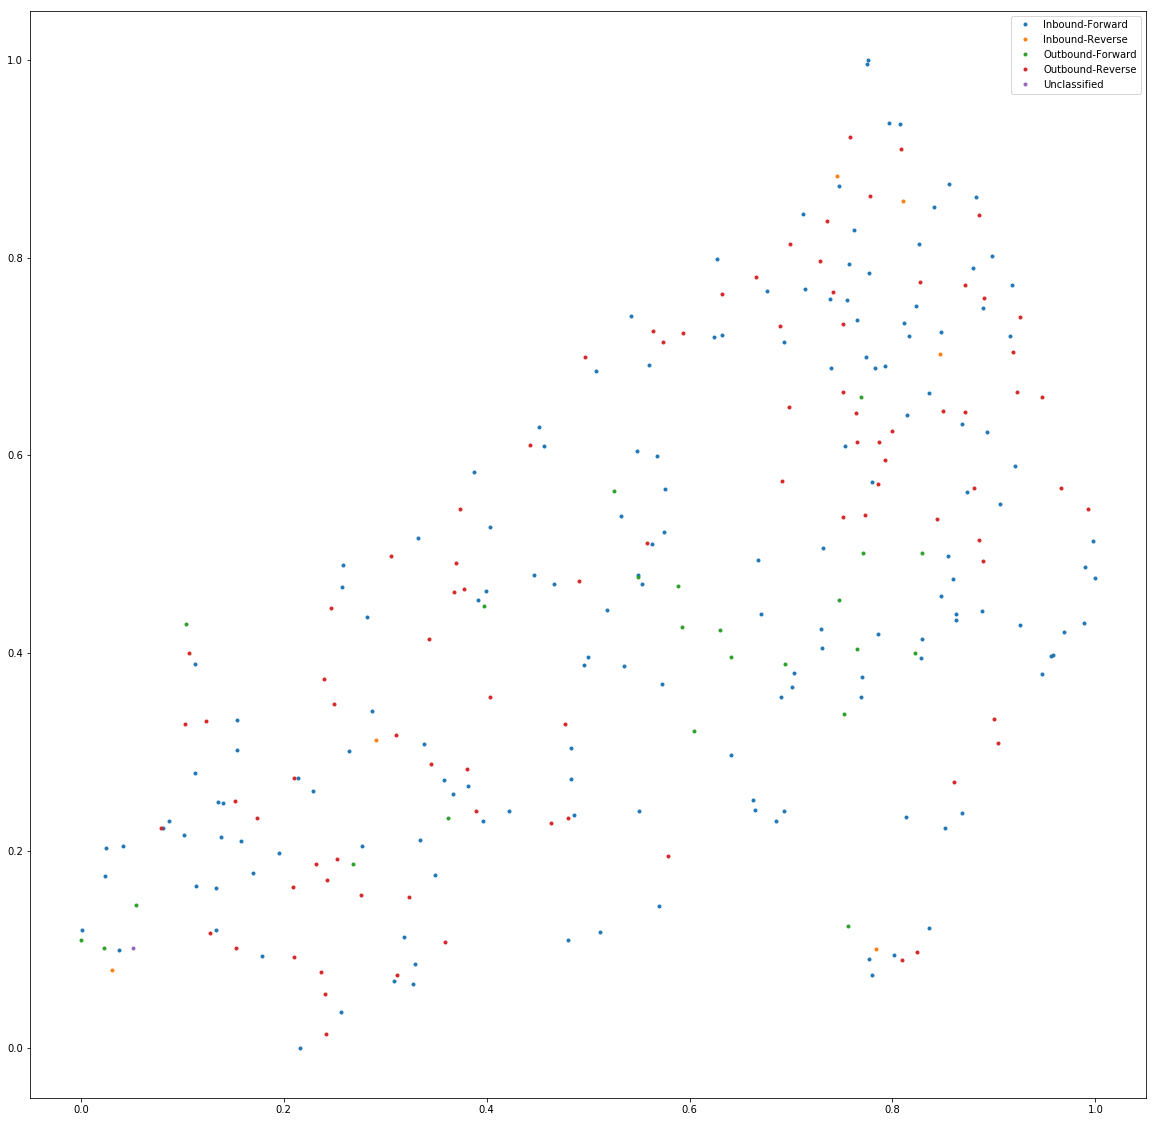

In [10]:
import umap


model = umap.UMAP(n_neighbors=5, min_dist=0.1,
                  metric='correlation')
images = np.moveaxis(posterior_density_ca1.values.copy(), 1, 2)
targets = replay_info.predicted_state.values
data = images.reshape((n_replay, -1)).copy()

fig, ax = plt.subplots(figsize=(20, 20))
plot_components(data, model, images=None, targets=targets,
                ax=ax, cmap='viridis')
plt.legend();

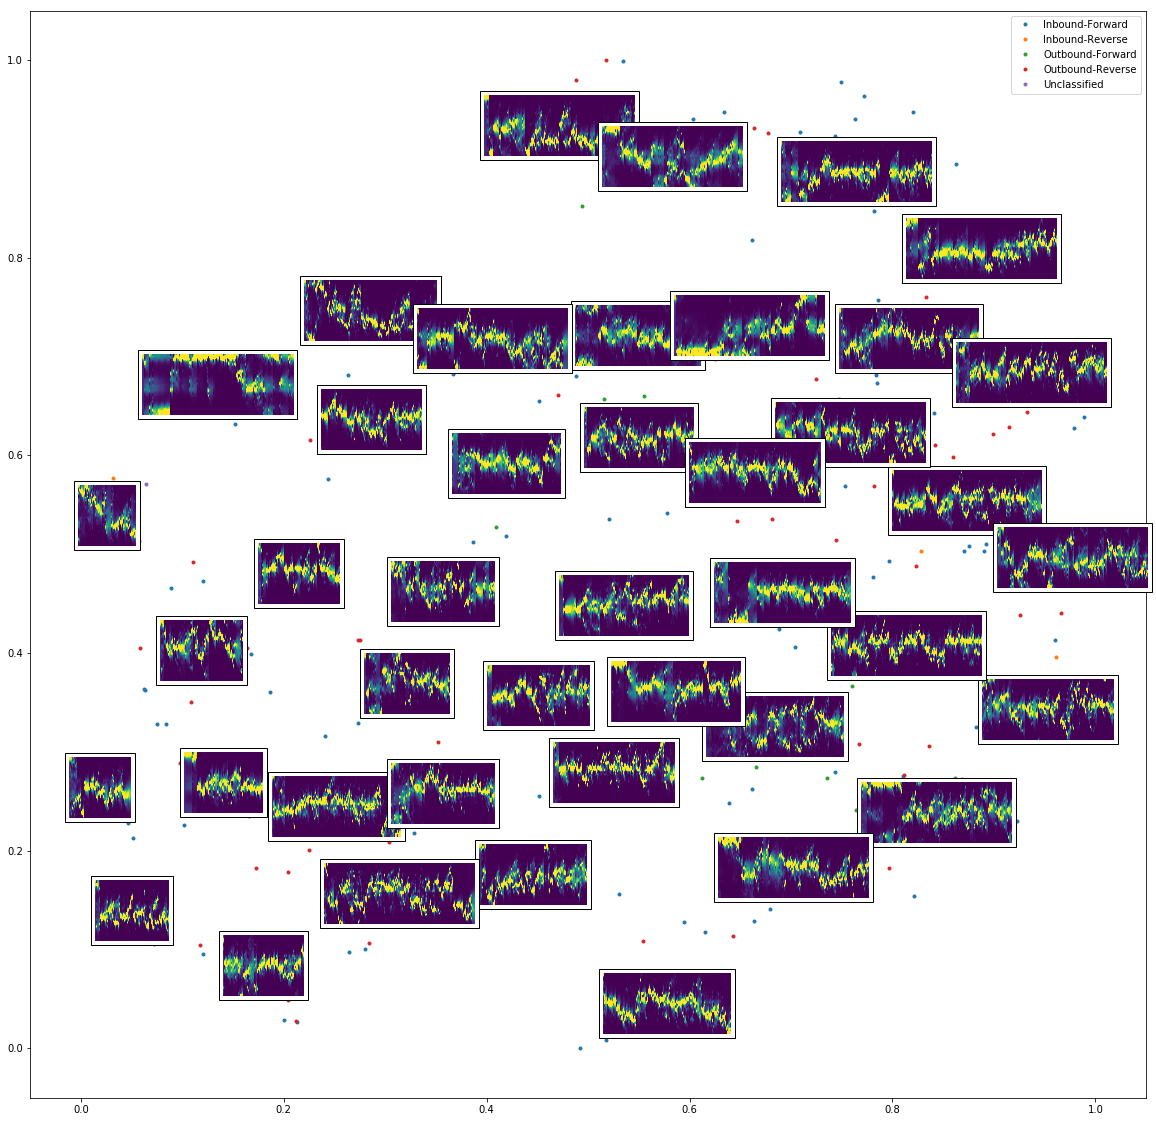

In [11]:
fig, ax = plt.subplots(figsize=(20, 20))
plot_components(data, model, images=images, targets=targets,
                ax=ax, thumb_frac=0.10, cmap='viridis')
plt.legend();

In [12]:
from scipy.spatial.distance import cdist
from lap import lapjv


def plot_components_grid(data, model, images,
                         targets=None, cmap='gray',
                         subplot_size=2):
    
    n_data = data.shape[0]
    n_cols = np.ceil(np.sqrt(n_data)).astype(np.int)
    figsize = (col_wrap * subplot_size, n_row * subplot_size)
    
    fig, axes = plt.subplots(n_cols, n_cols,
                             figsize=figsize,
                             sharex=True, sharey=True,
                             subplot_kw=dict(xticks=[], yticks=[]))
    
    proj = model.fit_transform(data)
    proj -= proj.min(axis=0)
    proj /= proj.max(axis=0)
    

    x = np.arange(n_cols)
    grid = np.stack(np.meshgrid(x, x), axis=2).reshape(-1, 2)

    cost_matrix = cdist(grid, proj, "sqeuclidean").astype(np.float64)
    cost_matrix *= 1E6 / cost_matrix.max()
    _, row_assignments, col_assignments = lapjv(cost_matrix, extend_cost=True)
    grid_jv = grid[col_assignments]
    vmax = np.quantile(images, 0.95)

    for (row_ind, col_ind), img in zip(grid_jv, images):
        axes[row_ind, col_ind].pcolorfast(
            img, cmap=cmap, vmin=0.0, vmax=vmax)


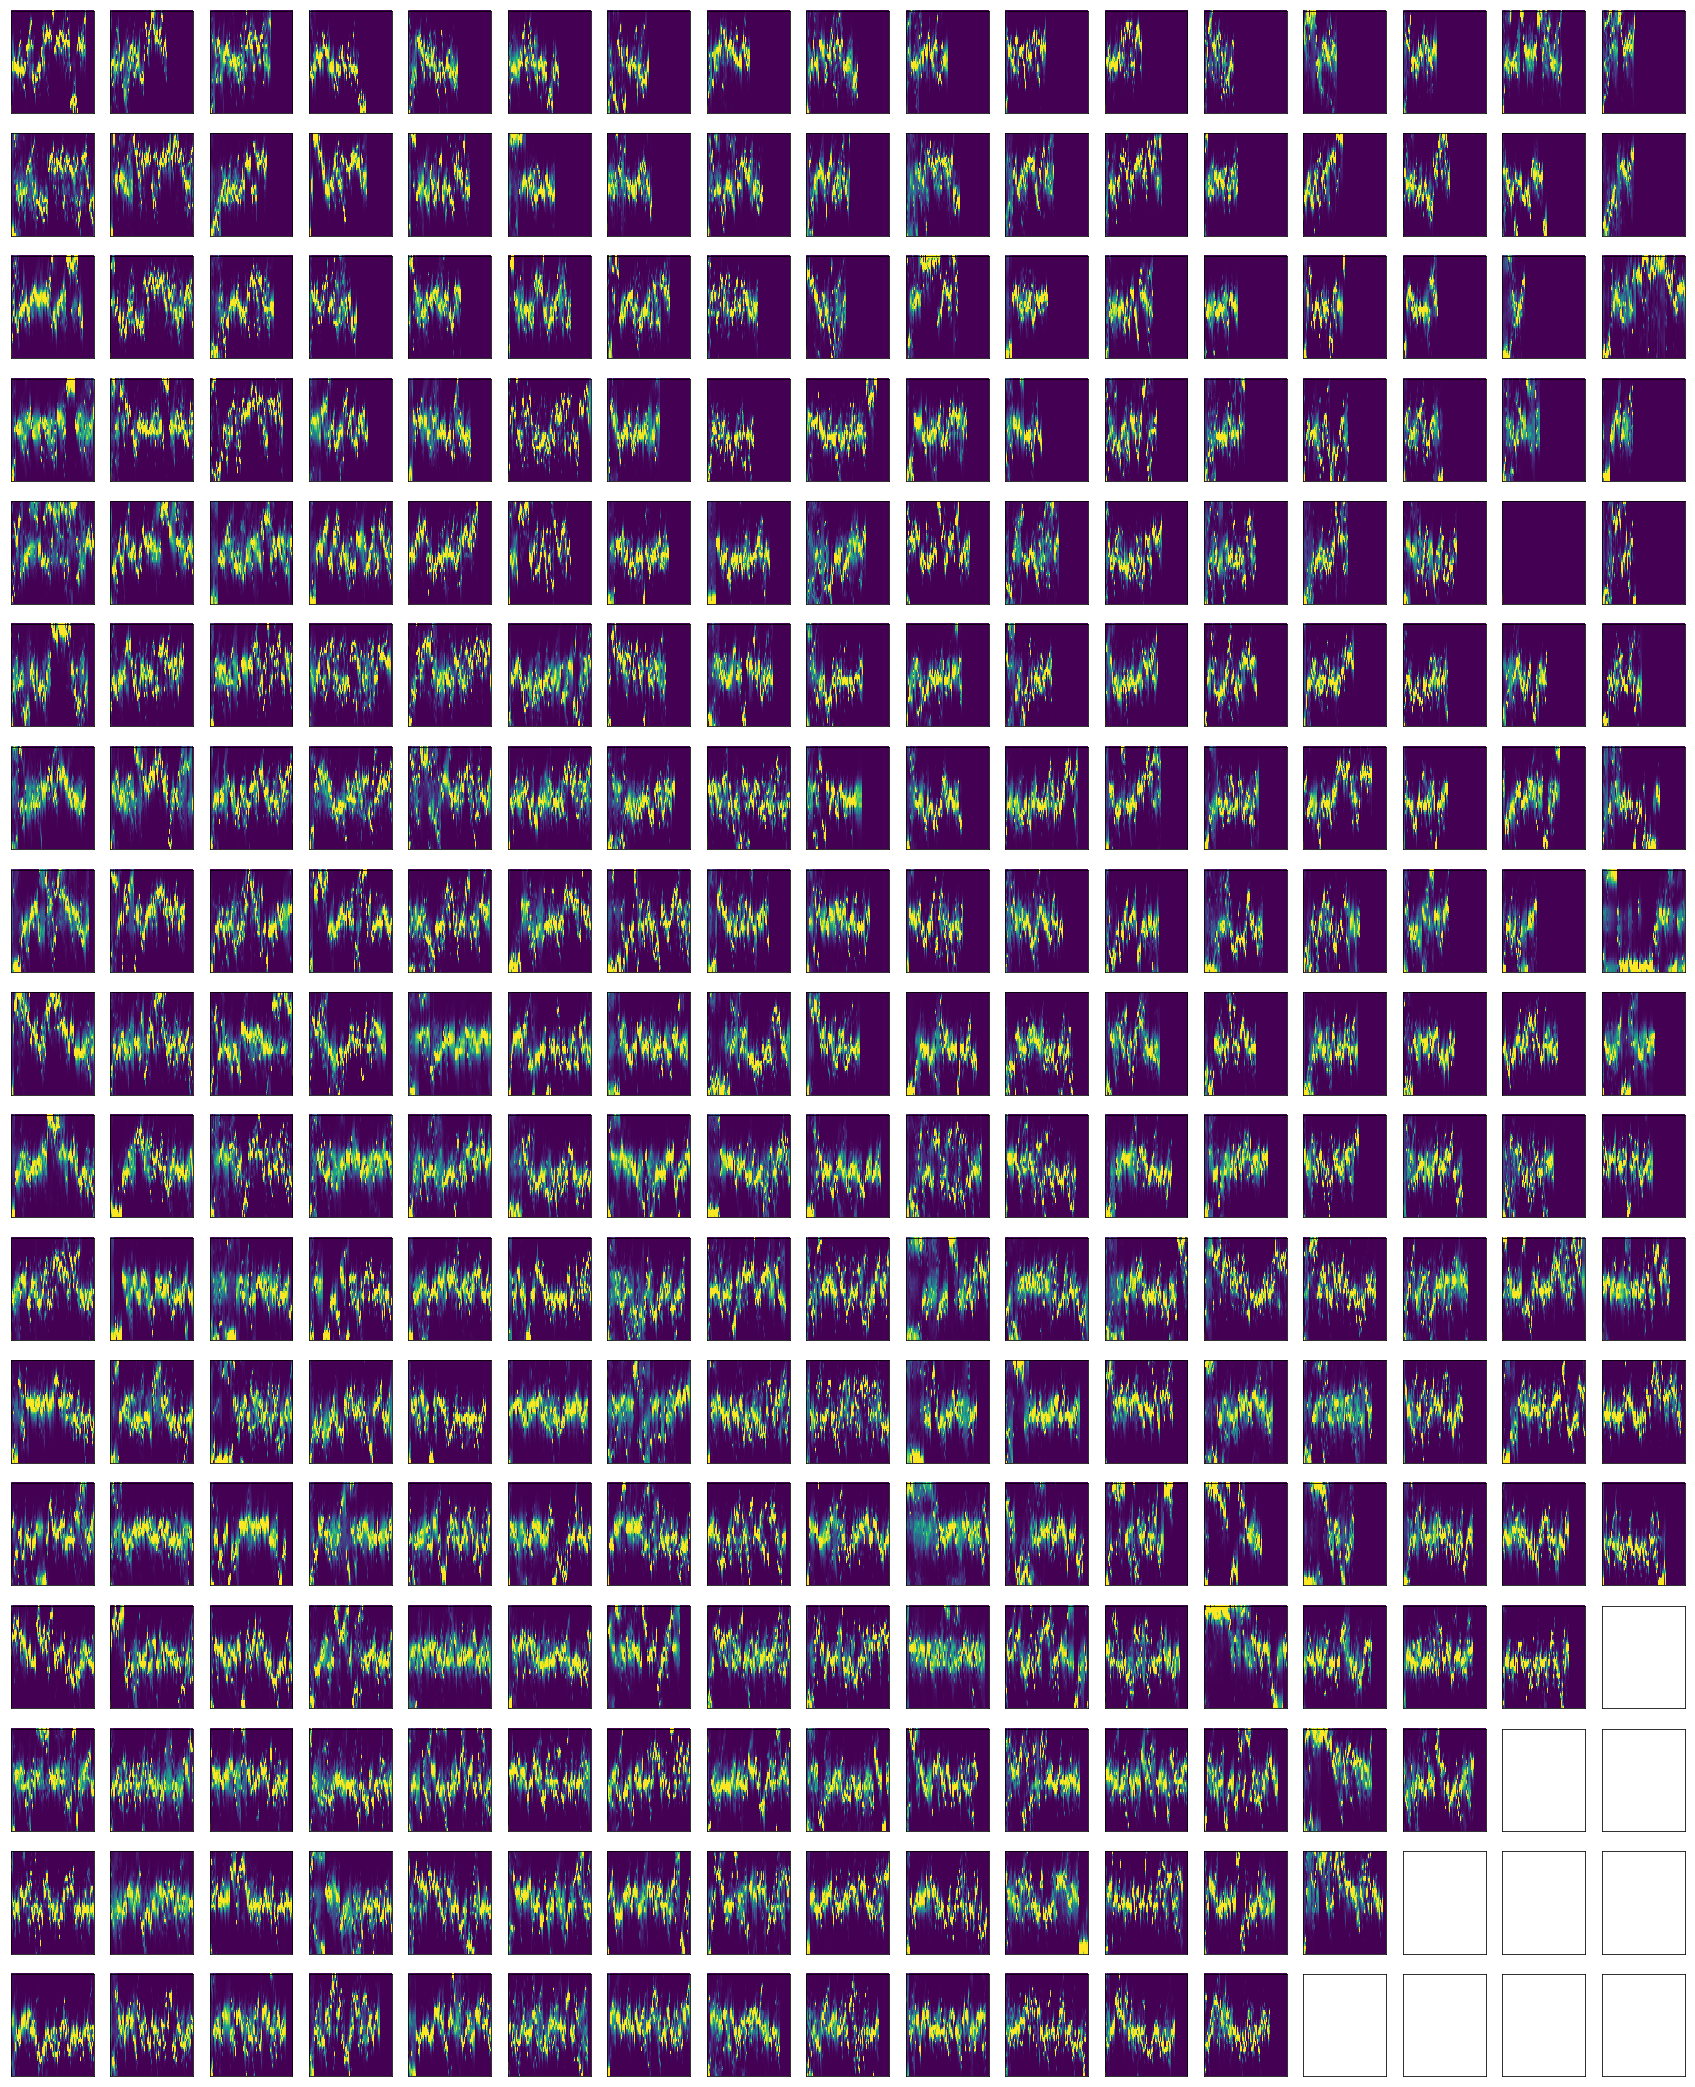

In [13]:
plot_components_grid(data, model, images=images, cmap='viridis')